In [6]:
import sys
print(sys.path)


['c:\\Users\\paras\\OneDrive\\Desktop\\Projects\\CV_final', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\paras\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages', 'C:\\Users\\paras\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32', 'C:\\Users\\paras\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\paras\\AppD

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

In [4]:


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define RMSE loss function
def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

# Define a function for plotting training and validation loss
def plot_loss(train_loss, val_loss, test_loss=None):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    if test_loss is not None:
        plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.show()


In [5]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [6]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms without augmentation for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

# Define data transforms for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [8]:


# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

In [2]:

# Split training set into training and validation sets
# Using a 80-20 split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with early stopping
num_epochs = 20
patience = 5  # Number of epochs to wait before early stopping if validation loss doesn't improve
min_val_loss = float('inf')
no_improvement_counter = 0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}...')
            break

torch.save(model.state_dict(), 'autoencoder_model_with_Aug.pth')


# Plotting loss curves
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 5))
    num_images_to_show = 5
    for i in range(num_images_to_show):
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


from torchsummary import summary


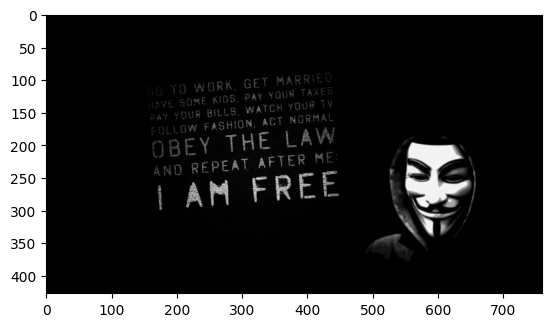

In [14]:
img = plt.imread("img.jpeg")
plt.imshow(img)

In [10]:


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:

# Initialize the model with the same architecture
model = Autoencoder()

# Load the saved parameters into the model (map to CPU)
model.load_state_dict(torch.load('autoencoder_model_with_Aug.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): C

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'function'>


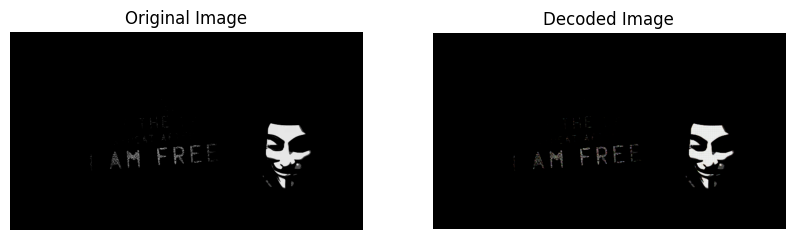

In [27]:


def get_image_files(folder_path = "images/"):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('.jpeg', '.jpg', '.png'))]
    return image_files

image_files = get_image_files()

# # Define a function to encode and decode the image
# def encode_decode_image(image_tensor):
#         # Encode the image
#         encoded_image = model.encoder(image_tensor)

#         # Decode the encoded image
#         decoded_image = model.decoder(encoded_image)

#         # Convert the decoded image tensor back to numpy array
#         decoded_image_np = decoded_image.squeeze(0).detach().numpy()

#         return decoded_image_np

def encode_decode_image(image_tensor, output_path="output/"):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    # # Optionally save the image
    # if output_path:
    #     # Get the base filename of the original image
    #     base_filename = "img_encoded_decoded"
        
    #     # Construct the output filename with the appropriate extension
    #     output_filename = os.path.join(output_path, base_filename)
    #     print(output_filename)
        
    #     # Save the image with the constructed output filename
    #     plt.imsave(output_filename, decoded_image_np)

    return decoded_image_np

    # Function to display images
def display_images(original_image, decoded_image):
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
        plt.title('Original Image')
        plt.axis('off')

        # Plot decoded image
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
        plt.title('Decoded Image')
        plt.axis('off')

        plt.show()
# Open and process each image
for image_path in image_files:
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to a numpy array
    image_np = np.array(image)

    # Convert the image to a torch tensor and normalize it
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image_tensor = transform(image_np).unsqueeze(0)


    # Encode and decode the image
    # encoded_decoded_image = encode_decode_image(image_tensor)
    
    
    # Define the output path
    # outputs_path = "output/"

    # Create the output directory if it doesn't exist
    # os.makedirs(outputs_path, exist_ok=True)
    
    # Encode and decode the image
    encoded_decoded_image = encode_decode_image(image_tensor)

    
    print(type(encode_decode_image))

    # Display the original image and decoded image side by side
    display_images(image_tensor, torch.tensor(encoded_decoded_image))


In [28]:
import numpy as np
import cv2

def calculate_sag(wire_mask, original_image):
    # Skeletonize the wire mask
    skeleton = cv2.ximgproc.thinning(wire_mask)

    # Find contours of the skeleton
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sag_measurements = []

    # Iterate through each wire segment
    for contour in contours:
        # Calculate the convex hull of the contour
        hull = cv2.convexHull(contour)

        # Find the endpoints of the convex hull
        endpoints = hull[:, 0]

        # Overlay endpoints onto original image
        overlay = original_image.copy()
        for point in endpoints:
            cv2.circle(overlay, tuple(point), 5, (0, 255, 0), -1)
        
        # Combine original image and overlay
        overlayed_image = cv2.addWeighted(original_image, 0.5, overlay, 0.5, 0)

        # Calculate the reference line (straight line connecting endpoints)
        endpoint1, endpoint2 = endpoints[0], endpoints[-1]
        reference_line = np.polyfit((endpoint1[0], endpoint2[0]), (endpoint1[1], endpoint2[1]), 1)

        # Calculate sag by finding the maximum vertical distance between the wire and the reference line
        distances = []
        for point in contour:
            distance = np.abs(reference_line[0]*point[0][0] - point[0][1] + reference_line[1]) / np.sqrt(reference_line[0]**2 + 1)
            distances.append(distance)
        sag = max(distances)

        sag_measurements.append(sag)

        # Show image with endpoints overlayed
        cv2.imshow('Image with Endpoints', overlayed_image)
        cv2.waitKey(0)

    return sag_measurements

# Example usage
predicted_mask = cv2.imread('c12mask.jpg', cv2.IMREAD_GRAYSCALE)  # Load the predicted mask
original_image = cv2.imread('c12img.jpg')  # Load the original image
sag_measurements = calculate_sag(predicted_mask, original_image)

print("Sag measurements for each wire segment:")
for i, sag in enumerate(sag_measurements):
    print(f"Wire {i+1}: {sag} pixels")

# cv2.destroyAllWindows()


AttributeError: module 'cv2' has no attribute 'ximgproc'

In [29]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
from skimage import img_as_ubyte

def calculate_sag(wire_mask, original_image):
    # Convert the wire mask to binary image
    _, binary_wire_mask = cv2.threshold(wire_mask, 128, 255, cv2.THRESH_BINARY)

    # Skeletonize the wire mask
    skeleton = skeletonize(binary_wire_mask)

    # Convert the skeleton to uint8 format for visualization
    skeleton = img_as_ubyte(skeleton)

    # Find contours of the skeleton
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sag_measurements = []

    # Iterate through each wire segment
    for contour in contours:
        # Calculate the convex hull of the contour
        hull = cv2.convexHull(contour)

        # Find the endpoints of the convex hull
        endpoints = hull[:, 0]

        # Overlay endpoints onto original image
        overlay = original_image.copy()
        for point in endpoints:
            cv2.circle(overlay, tuple(point), 5, (0, 255, 0), -1)
        
        # Combine original image and overlay
        overlayed_image = cv2.addWeighted(original_image, 0.5, overlay, 0.5, 0)

        # Calculate the reference line (straight line connecting endpoints)
        endpoint1, endpoint2 = endpoints[0], endpoints[-1]
        reference_line = np.polyfit((endpoint1[0], endpoint2[0]), (endpoint1[1], endpoint2[1]), 1)

        # Calculate sag by finding the maximum vertical distance between the wire and the reference line
        distances = []
        for point in contour:
            distance = np.abs(reference_line[0]*point[0][0] - point[0][1] + reference_line[1]) / np.sqrt(reference_line[0]**2 + 1)
            distances.append(distance)
        sag = max(distances)

        sag_measurements.append(sag)

        # Show image with endpoints overlayed
        cv2.imshow('Image with Endpoints', overlayed_image)
        cv2.waitKey(0)

    return sag_measurements

# Example usage
predicted_mask = cv2.imread('c12mask.jpg', cv2.IMREAD_GRAYSCALE)  # Load the predicted mask
original_image = cv2.imread('c12img.jpg')  # Load the original image
sag_measurements = calculate_sag(predicted_mask, original_image)

print("Sag measurements for each wire segment:")
for i, sag in enumerate(sag_measurements):
    print(f"Wire {i+1}: {sag} pixels")

# cv2.destroyAllWindows()


Sag measurements for each wire segment:
Wire 1: 2348.8857718545173 pixels


In [32]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
from skimage import img_as_ubyte

def calculate_sag(wire_mask, original_image):
    # Convert the wire mask to binary image
    _, binary_wire_mask = cv2.threshold(wire_mask, 128, 255, cv2.THRESH_BINARY)

    # Skeletonize the wire mask
    skeleton = skeletonize(binary_wire_mask)

    # Convert the skeleton to uint8 format for visualization
    skeleton = img_as_ubyte(skeleton)

    # Find contours of the skeleton
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sag_measurements = []

    # Iterate through each wire segment
    for contour in contours:
        # Calculate the convex hull of the contour
        hull = cv2.convexHull(contour)

        # Find the endpoints of the convex hull
        endpoints = hull[:, 0]

        # Overlay endpoints onto original image
        overlay = original_image.copy()
        for point in endpoints:
            cv2.circle(overlay, tuple(point), 5, (0, 255, 0), -1)
        
        # Combine original image and overlay
        overlayed_image = cv2.addWeighted(original_image, 0.5, overlay, 0.5, 0)

        # Resize image for better visualization
        scale_percent = 50  # Adjust as needed
        width = int(overlayed_image.shape[1] * scale_percent / 100)
        height = int(overlayed_image.shape[0] * scale_percent / 100)
        resized_image = cv2.resize(overlayed_image, (width, height))

        # Show resized image with endpoints overlayed
        cv2.imshow('Image with Endpoints', resized_image)
        cv2.waitKey(0)

        # Calculate the reference line (straight line connecting endpoints)
        endpoint1, endpoint2 = endpoints[0], endpoints[-1]
        reference_line = np.polyfit((endpoint1[0], endpoint2[0]), (endpoint1[1], endpoint2[1]), 1)

        # Calculate sag by finding the maximum vertical distance between the wire and the reference line
        distances = []
        for point in contour:
            distance = np.abs(reference_line[0]*point[0][0] - point[0][1] + reference_line[1]) / np.sqrt(reference_line[0]**2 + 1)
            distances.append(distance)
        sag = max(distances)

        sag_measurements.append(sag)

    return sag_measurements

# Example usage
predicted_mask = cv2.imread('c12mask.jpg', cv2.IMREAD_GRAYSCALE)  # Load the predicted mask
original_image = cv2.imread('c12img.jpg')  # Load the original image
sag_measurements = calculate_sag(predicted_mask, original_image)

print("Sag measurements for each wire segment:")
for i, sag in enumerate(sag_measurements):
    print(f"Wire {i+1}: {sag} pixels")

# cv2.destroyAllWindows()


Sag measurements for each wire segment:
Wire 1: 2348.8857718545173 pixels
